<변별력없는 컬럼을 제거하기 위한 함수>

In [83]:
import pandas as pd
import numpy as np

data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

In [84]:
# 걸러낼 col을 모을 최종 list
total_filtered_list=[]

# (1) 연속형 컬럼 구분

In [85]:
feature_multi_values={}
for col in data.columns:
    unique_values=data[col].unique()
    feature_multi_values[col]=len(unique_values)

multi_values=dict(sorted(feature_multi_values.items(), key=lambda x:x[1]))

# print(sorted(set(multi_values.values())))

multi_values_list=[]
for key, value in multi_values.items():
    if value>=14:
        print(key, ": ",value)
        multi_values_list.append(key) #연속형 컬럼이름 추가

BP8 :  14
EC_lgw_2 :  16
EC_ind :  18
EC_wht_3 :  50
age :  62
EC_wht_2 :  94
HE_ht :  447
HE_wc :  496
HE_wt :  576
N_INTK :  4128
N_EN :  4128
N_WATER :  4128
N_PROT :  4128
N_FAT :  4128
N_CHO :  4128
DW_WBT_BMD :  4131
DW_WBT_pFT :  4131



###### BP8: 하루 평균 수면시간 00시간 (1~24), 99 모름

###### EC_wht_2: 전일제 근로시간 000시간 , 888비해당, 999모름

###### EC_wht_3: 시간제 근로시간 000시간 , 888비해당, 999모름

=> 연속형이지만 값의 수가 많지 않음 -> profiling


###### EC_lgw_2 :  16

###### EC_ind :  18

=> 두가지는 일자리 분류 코드(생산직, 사무직...)인데 값의 종류가 많은 것

나머지는 연속형 변수

###### 'HE_wc' : 허리둘레

###### 'N_WATER' : 수분섭취량 

###### 'N_CHO' : 탄수화물

###### 'HE_ht':신장

###### 'N_FAT': 지방섭취량

###### 'DW_WBT_pFT' : 체지방률

###### 'DW_WBT_BMD' : 총 골밀도

###### 'age' : 나이

###### 'HE_wt' : 체중

###### 'N_INTK' : 식품섭취량

###### 'N_EN' : 에너지 섭취량

###### 'N_PROT' : 단백질 섭취량

### 값의 수가 많지 않은 BP8,EC_wht_2,EC_wht_3을 버릴지 판단하기 위해 profiling

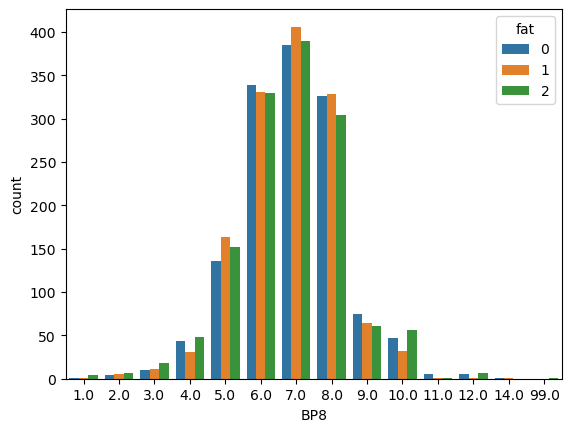

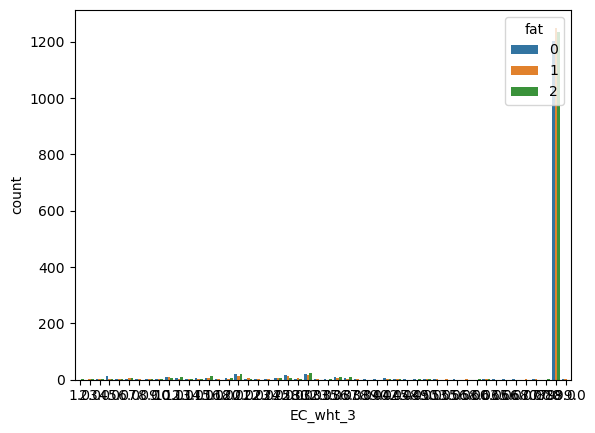

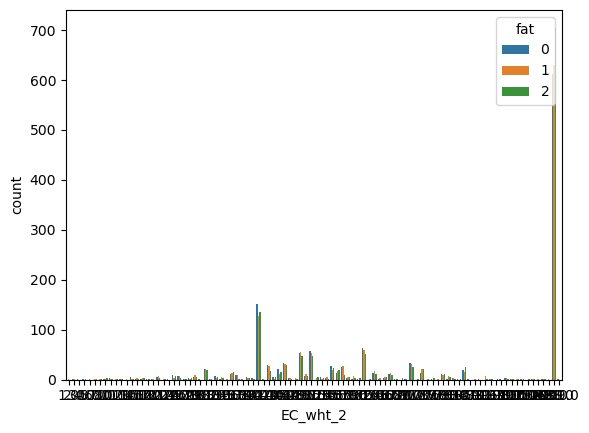

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

profile=['BP8','EC_wht_3','EC_wht_2']

for i in range(len(profile)):
    sns.countplot(x=profile[i], hue='fat', data=data)
    plt.legend(loc='upper right', title='fat')
    plt.show()

=> 'EC_wht_3', 'EC_wht_2'는 888 비해당이 대다수 이므로 제거  (일자리 분류 코드)

In [87]:
#최종 걸러낼 리스트에 추가
total_filtered_list.append(['EC_wht_3', 'EC_wht_2'])

#데이터셋에서도 제거
data=data.drop(['EC_wht_3', 'EC_wht_2'], axis=1)

최종 연속형 컬럼 리스트(continuous_columns)

In [88]:
continuous_columns=set(multi_values_list)-{'EC_wht_3', 'EC_wht_2', 'EC_lgw_2','EC_ind'}
continuous_columns=list(continuous_columns)
print(continuous_columns)

['N_WATER', 'N_FAT', 'age', 'HE_ht', 'N_INTK', 'HE_wt', 'N_EN', 'N_CHO', 'HE_wc', 'DW_WBT_pFT', 'BP8', 'DW_WBT_BMD', 'N_PROT']


# (2) 변별력이 떨어지는 컬럼 제거
특성의 고유값마다 fat의 값(정상, 과체중, 비만) 비율이 비슷한 경우 변별력이 떨어진다고 판단


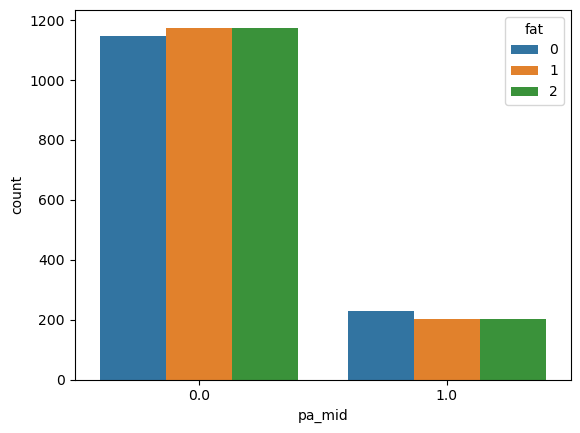

In [89]:
# 변별력 없는 컬럼 예시
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='pa_mid', hue='fat', data=data)
plt.legend(loc='upper right', title='fat')
plt.show()

<과정>

- 1. fat 값에 따라 데이터프레임을 3개로 나누었을 때 값 종류의 개수가 다른것이 존재하는 예외적인 요소는 따로 모아서 profiling

- 2. 예외적인 컬럼을 제외한 나머지 컬럼(81개)에 mse기반 필터링 알고리즘 적용

- 3. 그 후 예외적인 컬럼들에는 추가 분석 및 값 조정 후 알고리즘 적용

----

### (2-1) fat 값에 따라 데이터프레임을 3개로 나누었을 때 값 종류의 개수가 다른것이 존재하는 예외적인 요소는 따로 모아서 추가 분석

=> fat 값에 따라 값 종류의 개수가 다른 특성 조사 (diff라는 리스트에 저장)

In [90]:
# 연속형 column을 제외한 데이터 프레임 생성
ratio_data=data.drop(continuous_columns, axis=1)

fat값이 0인 레코드만 모은 데이터 프레임 값 비율


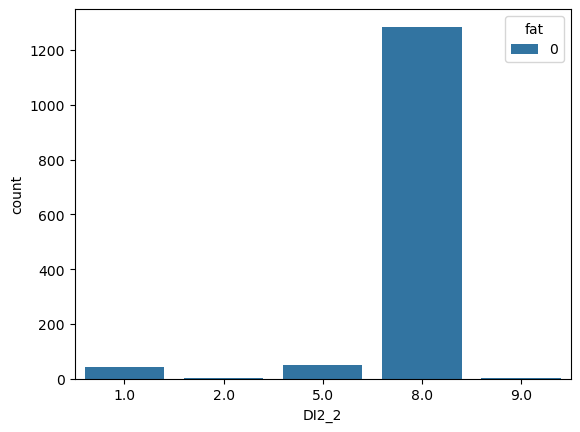

fat값이 1인 레코드만 모은 데이터 프레임 값 비율


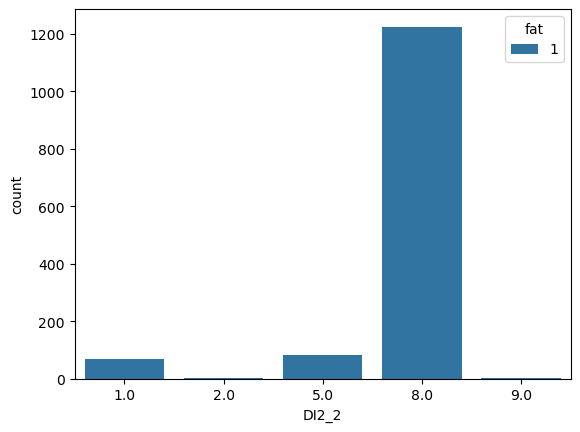

fat값이 2인 레코드만 모은 데이터 프레임 값 비율


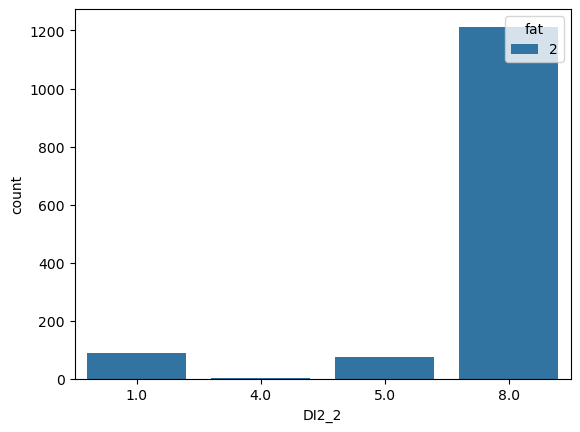

In [91]:
# fat 값에 따라 값 종류의 개수가 다른 특성 예시
fat_values = sorted(ratio_data['fat'].unique())

i=0
while i <3:
    fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]
    sns.countplot(x='DI2_2', hue='fat', data=fat_data)
    plt.legend(loc="upper right", title="fat")
    print(f"fat값이 {fat_values[i]}인 레코드만 모은 데이터 프레임 값 비율")
    plt.show()
    i+=1

In [92]:
diff = []

for col in ratio_data.columns:
    values_list = []
    i = 0
    while i < 3:    # fat값 0, 1, 2에 따라 반복
        fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]  # fat 값이 0인 레코드로만 만든 데이터프레임, 1로 만든, 2로 만든
        values_list.append(fat_data[col].unique())  # 해당 열(col)에서 고유한 값들을 가져와서 values_list에 추가
        i+=1
    if ( (len(values_list[0]) != len(values_list[1])) or (len(values_list[0]) != len(values_list[2])) or (len(values_list[1]) != len(values_list[2]))):
        diff.append(col)

print("fat 값에 따라 값 종류의 개수가 다른 특성")
print(diff)

fat 값에 따라 값 종류의 개수가 다른 특성
['genertn', 'D_1_1', 'DI2_2', 'DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg', 'LQ4_00', 'EC_lgw_2', 'EC_pjob_4', 'BO1_1', 'BO1_3', 'BD1_11', 'BD2_1', 'BP1', 'L_SNA_FQ', 'L_OUT_FQ', 'L_BR_FAM', 'L_LN_FAM', 'L_DN_FAM', 'LK_GD', 'LK_GD_P1', 'LK_GD_P2', 'LK_GD_P3', 'LK_GD_P4', 'LK_GD_P5', 'LK_GD_P6', 'LK_LAB', 'N_DIET']


### (2.2) 예외적인 컬럼을 제외한 나머지 컬럼(81개)에 mse기반 필터링 알고리즘 적용

In [93]:
# fat값에 따라 값 종류의 개수가 다른 특성 제외
ratio_data=ratio_data.drop(diff, axis=1)

In [94]:
def mse(avg_list, total_list):
    mse_list=[]
    for i in range(len(avg_list)):     # i : 요소 인덱스 "요소개수만큼 mse 계산 ex) 설문값이 5개면 mse도 5개 (fat값에 따라 3개의 값이 있을때 이 3개의 값을 평균값과 비교)""
        mse = sum((avg_list[i] - total_list[j][i]) ** 2 for j in range(len(total_list))) / len(total_list)    # j : 리스트 인덱스 "fat개수만큼 (= total list안의 리스트개수)"
        mse_list.append(mse)
    return mse_list

In [95]:
import statistics
# 걸러낼col의 이름을 추가할 리스트

def mse_col_filter(ratio_data, threshold):
    un_col=[]
    
    fat_values = sorted(ratio_data['fat'].unique())
    for col in ratio_data.columns:
        value_list = [] # 딕셔너리를 추가할 리스트
        value_list_2 = [] #딕셔너리의 value들의 전체값 대비 비율을 리스트로 만들어서 추가할 리스트
        i = 0
        
        # print(col) #현재 column
        while i < 3:    #fat값 0,1,2에 따라 반복
            fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]       #fat값이 0인 레코드로만 만든 데이터프레임, 1로만든, 2로만든
            origin_dict=fat_data[col].value_counts().to_dict()       #value_list에 각 값 종류와 개수가 맵핑된 딕셔너리로 추가
            value_list.append(dict(sorted(origin_dict.items())))
            i += 1 
        # print(value_list)
        
        for i in range(len(value_list)):
            total_value = sum(value_list[i].values())   #value_list의 i번째 리스트의 값 총합
            new_dict = {key: round((value / total_value), 2) for key, value in value_list[i].items()}   #키에 i번째 리스트의 각 값을 총합으로 나눈 평균값을 매핑시킴 (소수점 둘째자리)
            value_list_2.append(new_dict)       # value_list_2에는 각 리스트의 요소가 전체 값 기준 비율로 저장됨
        
        # print("비율")
        total_list = [list(d.values()) for d in value_list_2]   # value_list_2에 저장된 딕셔너리들의 value들을 리스트화시킴
        # print(total_list)
        
        #각 리스트별 같은 위치의 요소의 평균구하기 -> 하나의 리스트의 총 요소개수만큼의 평균이 나와야함
        # 예를 들어 설문 값이 1,2,3,4 -> 총 4개의 평균값 필요 (fat1일때의 1이라고 설문한 비율의 평균)
        
        #total_list에는 총 3개의 리스트가 저장되어있음
        # for문으로 1번째 리스트에서 0번째 값+2번째 리스트의 0번째 값 + 3번째 리스트의 0번째 값
        # => 값 종류의 개수만큼 while문, 그안에서 for문으로 각 리스트의 i번째 값 가져와서 합치고 총 개수로 나누기
        list_elem_length=len(total_list[0])         # 값의 종류의 개수가 동일한것만 남겼기 때문에 가능함
        k=0
        avg_list=[]    #평균값 넣을 리스트
        while(k<list_elem_length):  # 만약 값 개수가 5개라고 가정하면 총 5번 반복 (요소 인덱스)
            i_elem=0
            for i in range(3):     #total_list의 각 리스트(fat 0, 1, 2)를 순회하는 인덱스
                i_elem +=total_list[i][k]
            avg_list.append(round(i_elem/3,2))
            k+=1
        # print("평균값")
        # print(avg_list)
        mse_list=mse(avg_list,total_list)
        # print("mse 값")
        # print(mse_list)
        # print("mse 평균값")
        # print(statistics.mean(mse_list))
        
        # 임의의 mse 평균값 이하의 column을 un_col리스트에 추가
        if(statistics.mean(mse_list)<threshold):
            un_col.append(col)
        

    # 최종적으로 걸러낼 col 리스트
    # print("---"*100)
    # print("임계값 이하의 컬럼들")
    # print(un_col)
    print("전체 개수: ", len(ratio_data.columns))
    print("걸러진 개수: ", len(un_col))
    return(un_col) # 걸러낼 리스트 반환

81개 중 68개를 걸러낼 정도로 임계값(0.001) 설정-> 필터링

In [96]:
filterd_list=mse_col_filter(ratio_data, 0.001)
total_filtered_list.append(filterd_list) # data에서 걸러낼 컬럼의 최종 리스트에 추가

전체 개수:  81
걸러진 개수:  68


# (2.3) 값의 비율이 없어서 따로 빼두었던 예외적인 컬럼들 값 조정 및 알고리즘 적용

In [97]:
diff_data=data[diff +['fat']]

In [98]:
# profile=diff
# for i in range(len(profile)):
#     sns.countplot(x=profile[i], hue='fat', data=diff_data)
#     plt.legend(loc='upper right', title='fat')
#     print(profile[i])
#     plt.show()

###### 'DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg'

=> DROP (0,1이 거의 없고 9에 대다수몰려있음) : 모름이 대다수임

In [99]:
drop_list=['DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg', 'DI2_2']
diff_data=diff_data.drop(drop_list, axis=1)

total_filtered_list.append(drop_list)

###### D_1_1 : 의미있는 비율로 판단, 9(모름)에 해당하는 레코드를 제거(거의 없음)

###### genertn: 의미있는 비율로 판단, 9에 해당하는 레코드를 제거(거의 없음)

###### LQ4_00 : 9 레코드 제거

###### EC_lgw_2 : 의미있는 비율로 판단, 77에 해당하는 레코드 제거

###### EC_pjob_4: 의미있는 비율로 판단, 99,9에 해당하는 레코드 제거

###### BO1_1 : 9레코드 제거

###### BO1_3: 9레코드 제거

###### BD1_11 :9레코드 제거

###### BD2_1:9레코드 제거

###### BP1:9레코드 제거...

###### 대부분 9가 없음

=> 9,99,77에 해당하는 레코드 제거 후 필터링 알고리즘 적용

In [100]:
rows_with_9 = diff_data[diff_data.eq(9).any(axis=1)]
diff_data=diff_data[~diff_data.eq(9).any(axis=1)]

rows_with_99= diff_data[diff_data.eq(99).any(axis=1)]
diff_data=diff_data[~diff_data.eq(99).any(axis=1)]

rows_with_77=diff_data[diff_data.eq(77).any(axis=1)]
diff_data=diff_data[~diff_data.eq(77).any(axis=1)]

남은 컬럼들 다시 유사도 조사

In [101]:
filterd_list=mse_col_filter(diff_data, 0.001)

전체 개수:  25
걸러진 개수:  22


In [102]:
total_filtered_list.append(filterd_list)

# 3. 최종 컬럼 확인

In [103]:
data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

In [104]:
# 걸러낼 컬럼
total_unpacked_list=[]
for i in total_filtered_list:
    for j in range(len(i)):
        total_unpacked_list.append(i[j])

set_fat={'fat'}
set_total=set(total_unpacked_list)-set_fat
total_unpacked_list=list(set_total)

In [105]:
data=data.drop(total_unpacked_list, axis=1)

In [106]:
last_columns=list(data.columns)
print("걸러진 특성들:",total_unpacked_list)
print("남은 특성들:",last_columns)
print("남은 특성 개수:", len(last_columns))

걸러진 특성들: ['ho_incm5', 'DC2_dg', 'DE2_dg', 'BS5_21', 'DI2_2', 'EC_pjob_4', 'LQ4_00', 'LQ_3EQL', 'DC1_dg', 'DK9_dg', 'DJ4_3', 'DI4_dg', 'DC5_dg', 'DI8_dg', 'edu', 'EC_wht_4', 'DC3_dg', 'DK8_dg', 'DK4_dg', 'EC_env_8', 'L_OUT_FQ', 'incm5', 'EC_env_5', 'DM4_dg', 'DI3_dg', 'BS9_2', 'allownc', 'LQ_2EQL', 'DK7_dg', 'LK_LB_IT', 'EC_wht_5', 'BS8_2', 'LK_GD_P5', 'LK_GD_P6', 'BS3_1', 'LK_EDU', 'BP1', 'DF2_dg', 'DC6_dg', 'L_BR_FAM', 'LK_GD_P2', 'LS_VIT', 'LK_GD', 'house', 'pa_mid', 'EC_env_7', 'LQ_4EQL', 'EC_wht_3', 'L_SNA_FQ', 'LQ_1EQL', 'EC_env_6', 'occp', 'EC_env_3', 'LK_GD_P3', 'LK_LAB', 'EC_lgw_2', 'L_LN_FAM', 'DL2_dg', 'BD1_11', 'EC_pjob_1', 'EC_env_4', 'pa_walk', 'DK2_dg', 'genertn', 'EC_wht_2', 'BE5_1', 'DE1_dg', 'DM6_dg', 'DJ4_dg', 'DC4_dg', 'marri_1', 'DM1_dg', 'DI2_dg', 'BS5_22', 'DJ8_dg', 'EC_ind', 'DL1_dg', 'DJ5_dg', 'LQ_5EQL', 'EC_occp', 'LK_GD_P7', 'LK_GD_P1', 'LS_FUN', 'DE1_32', 'sm_presnt', 'LF_SAFE', 'D_1_1', 'DN1_dg', 'EC_wht_1', 'DH4_dg', 'DJ6_dg', 'BD2_1', 'LK_GD_P4', 'DN2_dg',

In [107]:
# 위에서 분리해놓았던 연속형 특성
print("연속형 특성:",continuous_columns)

연속형 특성: ['N_WATER', 'N_FAT', 'age', 'HE_ht', 'N_INTK', 'HE_wt', 'N_EN', 'N_CHO', 'HE_wc', 'DW_WBT_pFT', 'BP8', 'DW_WBT_BMD', 'N_PROT']


In [108]:
#남은 특성 중 카테고리형 특성
category_columns=set(last_columns)-set(continuous_columns)
category_columns=list(category_columns)
print("카테고리형 특성", category_columns)

카테고리형 특성 ['BO1_1', 'BO1_3', 'sex', 'BO3_07', 'fat', 'DI1_2', 'BO3_09', 'BO3_12', 'DI1_dg', 'EC1_1', 'BO3_05', 'BO2_1', 'BO3_04', 'BO3_02', 'N_DIET', 'BO3_03', 'BO3_01']


------
pickle 파일로 저장해서 modeling.ipynb에서 사용

In [109]:
total_list=["continuous_columns", continuous_columns,
            "category_columns",category_columns]

In [110]:
import pickle
with open('total_list.pkl', 'wb') as f:
    pickle.dump(total_list, f)